Testing for an audio processing feature, based on Audacity's noise reduction and loudness normalization features.

In [1]:
#relative path finder 
import os

def pathfinder (base_path, target_path):
    relative_path = os.path.relpath(target_path, start=os.path.dirname(base_path))
    return relative_path



base_path = r"G:\Cloned Repos\Repo prueba 1\Binary-class\ClassificationCNN\CleanScratch.ipynb"
target_path = r"G:\Cloned Repos\Repo prueba 1\Binary-class\SimplifiedPythonFiles\KeyIsolator.py"

path=pathfinder(base_path, target_path)
print(path)


..\SimplifiedPythonFiles\KeyIsolator.py


# Step One: Normalization

For this section, we will use ffmpeg-normalize. More information [here](https://pypi.org/project/ffmpeg-normalize/).

In [2]:
import ffmpeg_normalize as normalizer
import torch

In [3]:
# For this and for denoiser, we'll use the same settings used in Audacity.
normalize = normalizer.FFmpegNormalize(normalization_type='ebu', target_level=-23, dual_mono=True, print_stats=True)
normalize.add_media_file("../Dataset-custom-audio/test-audio-not-split/010123.wav", "Normalized-010123.wav")
normalize.run_normalization()

You specified linear normalization, but the loudnorm filter reverted to dynamic normalization. This may lead to unexpected results.Consider your input settings, e.g. choose a lower target level or higher target loudness range.


[
    {
        "input_file": "../Dataset-custom-audio/test-audio-not-split/010123.wav",
        "output_file": "Normalized-010123.wav",
        "stream_id": 0,
        "ebu_pass1": {
            "input_i": -46.01,
            "input_tp": -23.21,
            "input_lra": 1.3,
            "input_thresh": -56.01,
            "output_i": -22.83,
            "output_tp": -2.0,
            "output_lra": 0.8,
            "output_thresh": -32.83,
            "normalization_type": "dynamic",
            "target_offset": -0.17
        },
        "ebu_pass2": {
            "input_i": -46.01,
            "input_tp": -23.21,
            "input_lra": 1.3,
            "input_thresh": -56.01,
            "output_i": -23.0,
            "output_tp": -2.0,
            "output_lra": 0.8,
            "output_thresh": -33.0,
            "normalization_type": "dynamic",
            "target_offset": -0.0
        },
        "mean": null,
        "max": null
    }
]


# Step Two: Noise Reduction

Based on Audacity's noise reduction, using noisereduce. More information [here](https://pypi.org/project/noisereduce/).


In [4]:
# Remove this comment to install noisereduce if needed
#%pip install noisereduce

In [3]:
import noisereduce as nr
from scipy.io import wavfile

#setting up device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


In [6]:
# obtain normalized file
rate_normal, data_normal = wavfile.read("Normalized-010123.wav")

In [7]:
device

'cuda'

## Stationary Noise

Stationary Noise Reduction acts on noise that is stationary in intensity and shape over time, like the hum of electronics.

In [6]:
import pydub
import math
import matplotlib.pyplot as plt

In [5]:
# Noise Reduction: 16 dB. Sensitivity: 2.0. Frequency smoothing bands: 12

audio_for_profile = pydub.AudioSegment.from_file("../Dataset-custom-audio/audio-standby-files/noise-profile/Noise.wav")

# find noise db and calculate noise threshold
threshold=audio_for_profile.dBFS+10

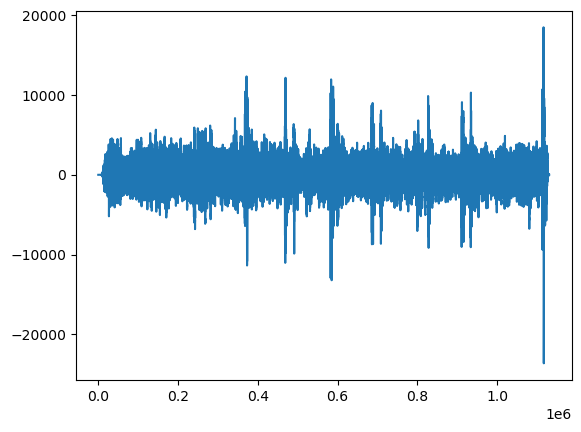

In [ ]:

#perform noise reduction
reduced_noise = nr.reduce_noise(y=data_normal, sr=rate_normal, stationary=True, prop_decrease=2.0, freq_mask_smooth_hz=500,device=device, n_std_thresh_stationary=200)
wavfile.write("reduced_noise_stat.wav", rate_normal, reduced_noise)

plt.plot(reduced_noise, label="Reduced Noise nonstat",  alpha=1)

## Non-stationary Noise

Non-stationary noise reduction targets background noise that is non-stationary and fluctuates over time, like the presence of an airplane flying overhead.

In [10]:
from scipy.signal import resample

C:\Users\Kat\AppData\Local\Temp\ipykernel_58232\100208463.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  noise_rate, noise_data = wavfile.read("../Dataset-custom-audio/audio-standby-files/noise-profile/Noise.wav") # noise profile, pre-normalized


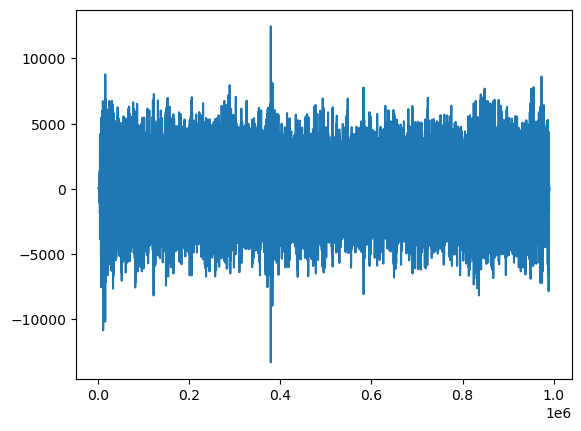

In [11]:
noise_rate, noise_data = wavfile.read("../Dataset-custom-audio/audio-standby-files/noise-profile/Noise.wav") # noise profile, pre-normalized

plt.plot(noise_data)
plt.show()

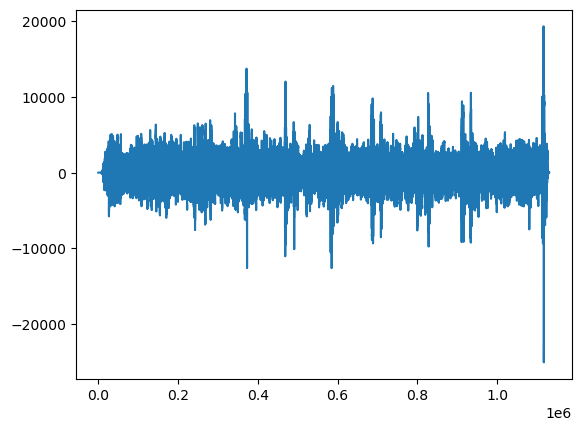

In [12]:
# Noise Reduction: 16 dB. Sensitivity: 2.0. Frequency smoothing bands: 12
#perform noise reduction
reduced_noise = nr.reduce_noise(y=data_normal, sr=rate_normal, y_noise=noise_data, stationary=False, prop_decrease=2.0, freq_mask_smooth_hz=500,device=device, thresh_n_mult_nonstationary=abs(threshold))
wavfile.write("reduced_noise_nonstat.wav", rate_normal, reduced_noise)

plt.plot(reduced_noise, label="Reduced Noise nonstat",  alpha=1)

## Graphs

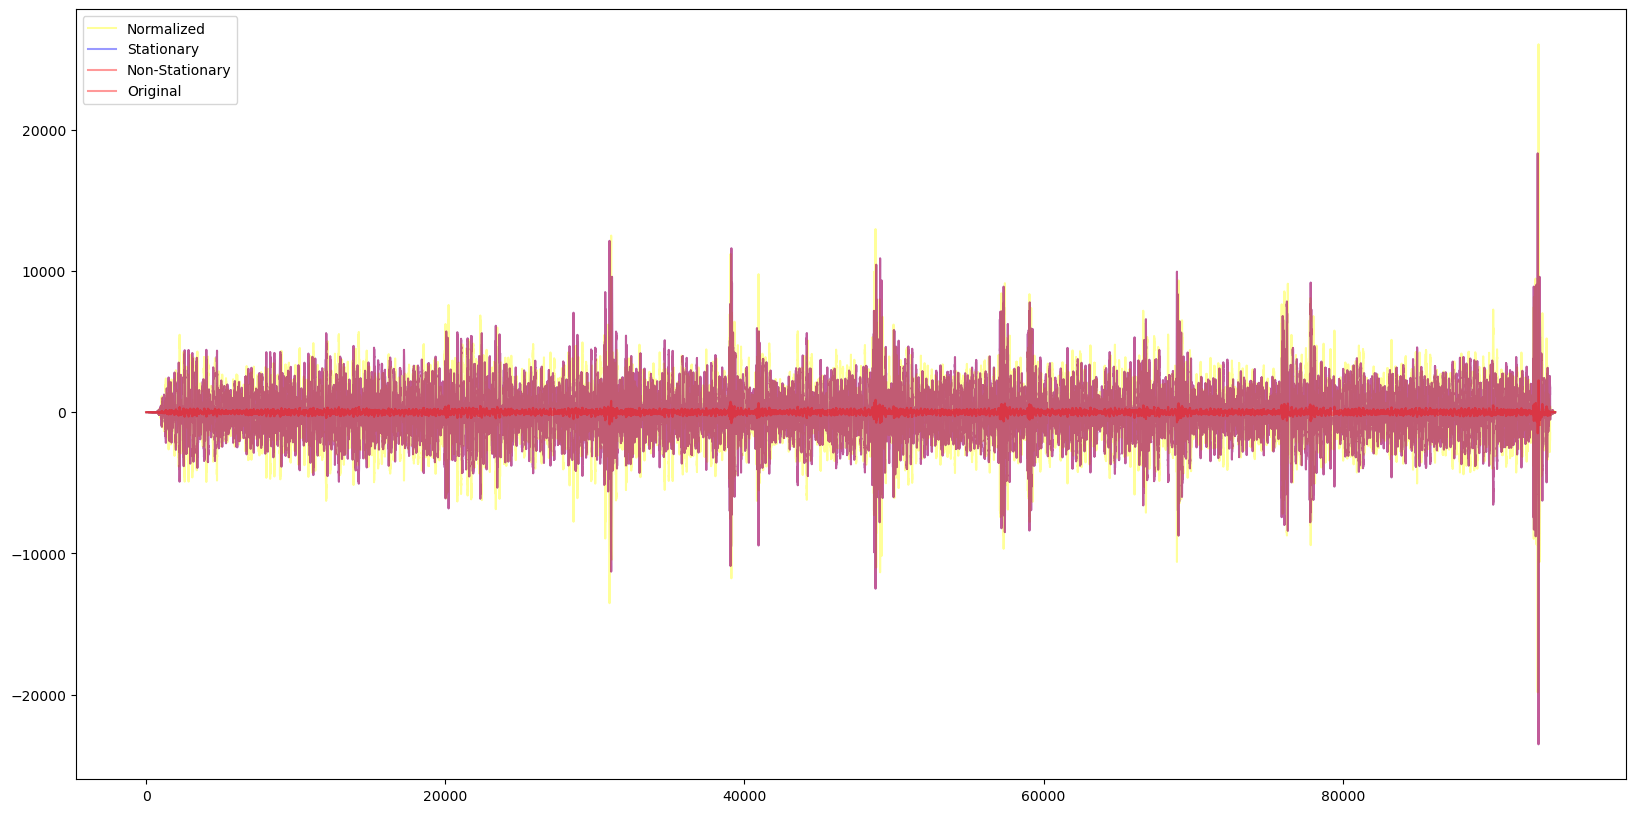

In [13]:
plt.figure(figsize=(20,10))
common_rate = 16000 #common sample rate for graphing

#graph normalized
data_normal_resampled = resample(data_normal, int(len(data_normal)*common_rate/rate_normal))
plt.plot(data_normal_resampled, label="Normalized", color="yellow", alpha=0.4)

#graph stationary
_, data_stat = wavfile.read("reduced_noise_stat.wav")
data_stat_resampled = resample(data_stat, int(len(data_stat)*common_rate/_))
plt.plot(data_stat_resampled, label="Stationary", color="blue", alpha=0.4)

#graph nonstationary
_, data_nonstat = wavfile.read("reduced_noise_stat.wav")
data_nonstat_resampled = resample(data_stat, int(len(data_stat)*common_rate/_))
plt.plot(data_nonstat_resampled, label="Non-Stationary", color="red", alpha=0.4)

#og
_,data_og = wavfile.read("../Dataset-custom-audio/test-audio-not-split/010123.wav")
#resampling with others' rate
data_og_resampled = resample(data_og, int(len(data_og)*common_rate/_))
plt.plot(data_og_resampled, label="Original", color="red", alpha=0.4)

plt.legend()
plt.show()

# Noise filtering methods and peak identification

## Peak identification and dividing audio into chunks by peaks

In the future, this will allow us to better identify each individual keystroke.

In [1]:
import pydub.silence
import numpy as np

def match_target_amplitude (aChunk, target_dBFS): #normalizing audio
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

def split_audio(audio, silence_length):
    #find average dbfs of audio first
    average=audio.dBFS

    #splitting audio
    chunks = pydub.silence.split_on_silence(
        audio, #audio file
        min_silence_len=silence_length, #length of required silence chunk in ms
        silence_thresh=average) #a chunk is silent if it's below this threshold
    
    # Convert chunks to numpy arrays
    chunk_arrays = [np.array(chunk.get_array_of_samples()) for chunk in chunks]

    
    #return amount of chunks
    return len(chunks), chunk_arrays



In [ ]:

#load audio files
audio_base = pydub.AudioSegment.from_file("../Dataset-custom-audio/test-audio-not-split/010123.wav")
audio_normalized = pydub.AudioSegment.from_file("Normalized-010123.wav")
audio_stat = pydub.AudioSegment.from_file("reduced_noise_stat.wav")
audio_nonstat = pydub.AudioSegment.from_file("reduced_noise_nonstat.wav")

In [2]:
from scipy.signal import find_peaks
def find_n_peaks(audio):

    #distance is the real kicker here. It's the minimum distance between peaks. Need to find a way to calculate it.
    audio_array=np.array(audio.get_array_of_samples())
    print(f'audio_array: {audio_array}')
    distance=(audio.frame_rate+threshold)/1.5
    print(f'distance: {distance}')
    print(f'audio mean: {audio.dBFS}')
    peaks,_=find_peaks(audio_array,prominence=75, height= (abs(audio.dBFS)), distance=distance)

    # Find median
    mean_peak_height = np.mean(audio_array[peaks])*.25
    median_peak_height = np.median(audio_array[peaks])*.25
    lower_limit=(median_peak_height+mean_peak_height)/2

    #Remove those under mdian
    peaks = peaks[audio_array[peaks] > lower_limit]

    #find peaks that are too close to each other and delete those
    #peak_diffs = np.diff(peaks)
    #avg_peak_diff = np.mean(peak_diffs)
    #peaks = np.delete(peaks, np.where(peak_diffs < avg_peak_diff/2))

    # Plot the audio data and the peaks
    plt.figure(figsize=(20, 10))
    plt.plot(audio_array, label='Audio Data')
    plt.plot(peaks, audio_array[peaks], "x", label='Peaks')
    plt.plot([0, len(audio_array)], [mean_peak_height, mean_peak_height], label='Mean Peak Height')
    plt.plot([0, len(audio_array)], [median_peak_height, median_peak_height], label='Median Peak Height')
    plt.plot([0, len(audio_array)], [lower_limit, lower_limit], label='Lower Limit')
    plt.legend()
    plt.show()

    return len(peaks)

In [3]:
def get_silence_length(expected_length,audio, rate): #audio must be pydub.AudioSegment
    audio_length=audio.duration_seconds*1000 #converted to ms
    silence_length=int(audio_length/expected_length/rate)
    return int(silence_length)

def divide_into_chunks(audio):
    expected_length=find_n_peaks(audio)
    print("Peak amount: "+str(expected_length))
    chunk_amount=500
    rate=0.1*expected_length
    counter=['','','']
    while expected_length!=chunk_amount:
        print("while")
        silence_length = get_silence_length(expected_length, audio, rate)
        print("silence:"+str(silence_length))
        chunk_amount, chunks = split_audio(audio, silence_length)
        print("Amount of chunks vs expected: "+str(chunk_amount)+"/"+str(expected_length))
        if counter[0]=='down' and counter[1]=='up' and counter[2]=='down':
            print("Rate is stuck; selecting closest accurate.")
            rate=rate+0.05
            break
        elif chunk_amount<expected_length:
            print("Augmenting rate.")
            rate=rate+0.05
            counter[2]=counter[1]
            counter[1]=counter[0]
            counter[0]='up'
        elif chunk_amount>expected_length:
            print("Diminishing rate.")
            rate=rate-0.05
            counter[2]=counter[1]
            counter[1]=counter[0]
            counter[0]='down'
        print("-----")
    return chunks, chunk_amount

## Base audio and Normalized only

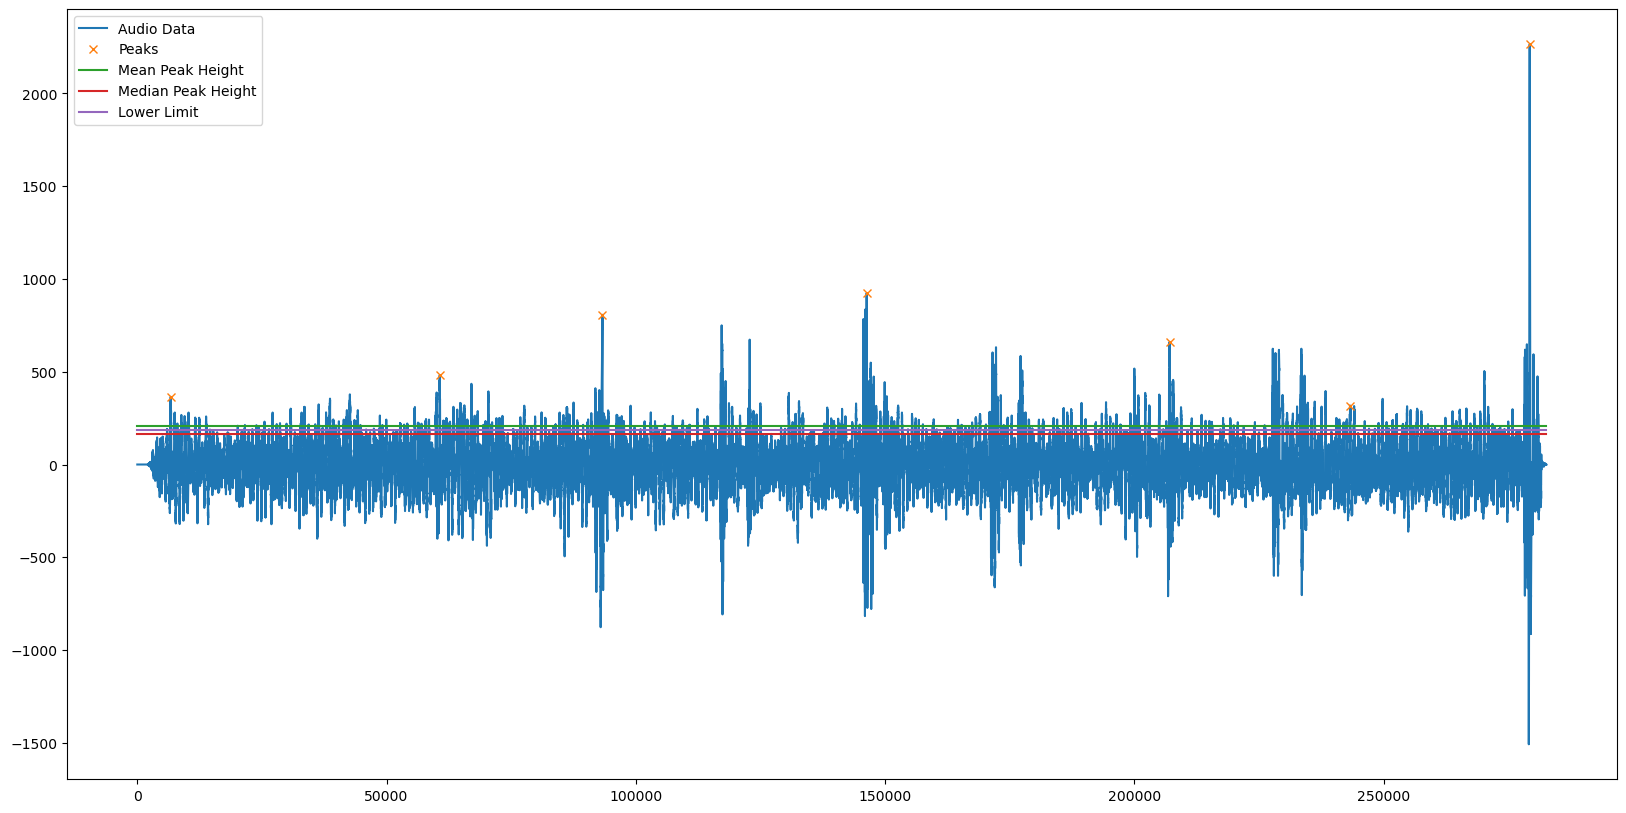

Peak amount: 7
while
silence:1201
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1121
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1051
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:989
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:934
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:885
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:841
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:801
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:764
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:731
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:700
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:672
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:647
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
s

In [17]:
base_chunks,base_chunks_n=divide_into_chunks(audio_base)

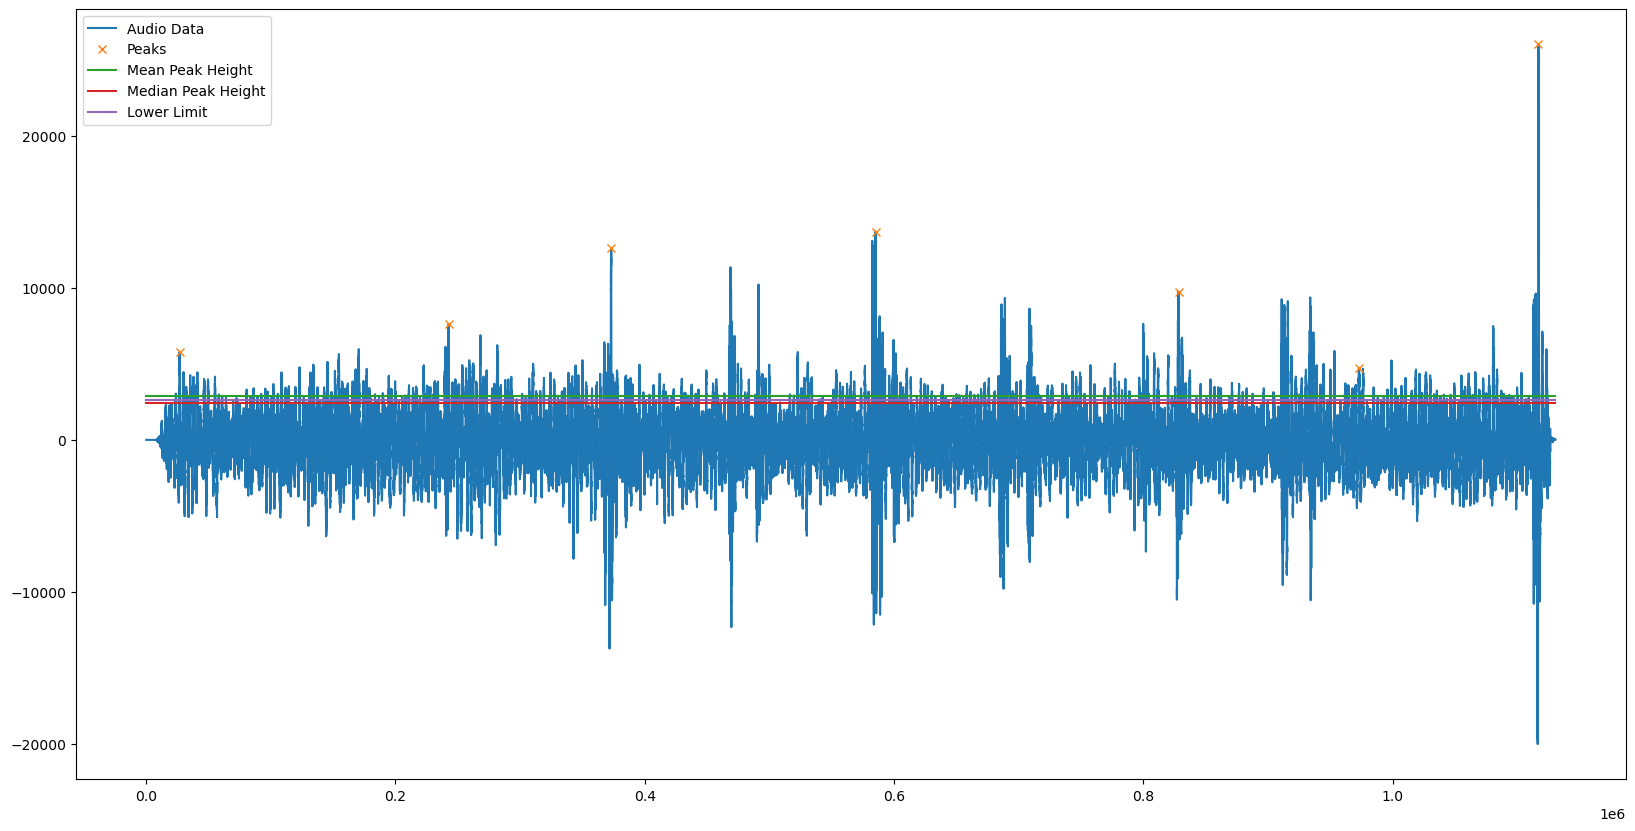

Peak amount: 7
while
silence:1201
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1121
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1051
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:989
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:934
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:885
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:841
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:801
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:764
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:731
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:700
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:672
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:647
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
s

In [18]:
normalized_chunks, normalized_chunks_n=divide_into_chunks(audio_normalized)

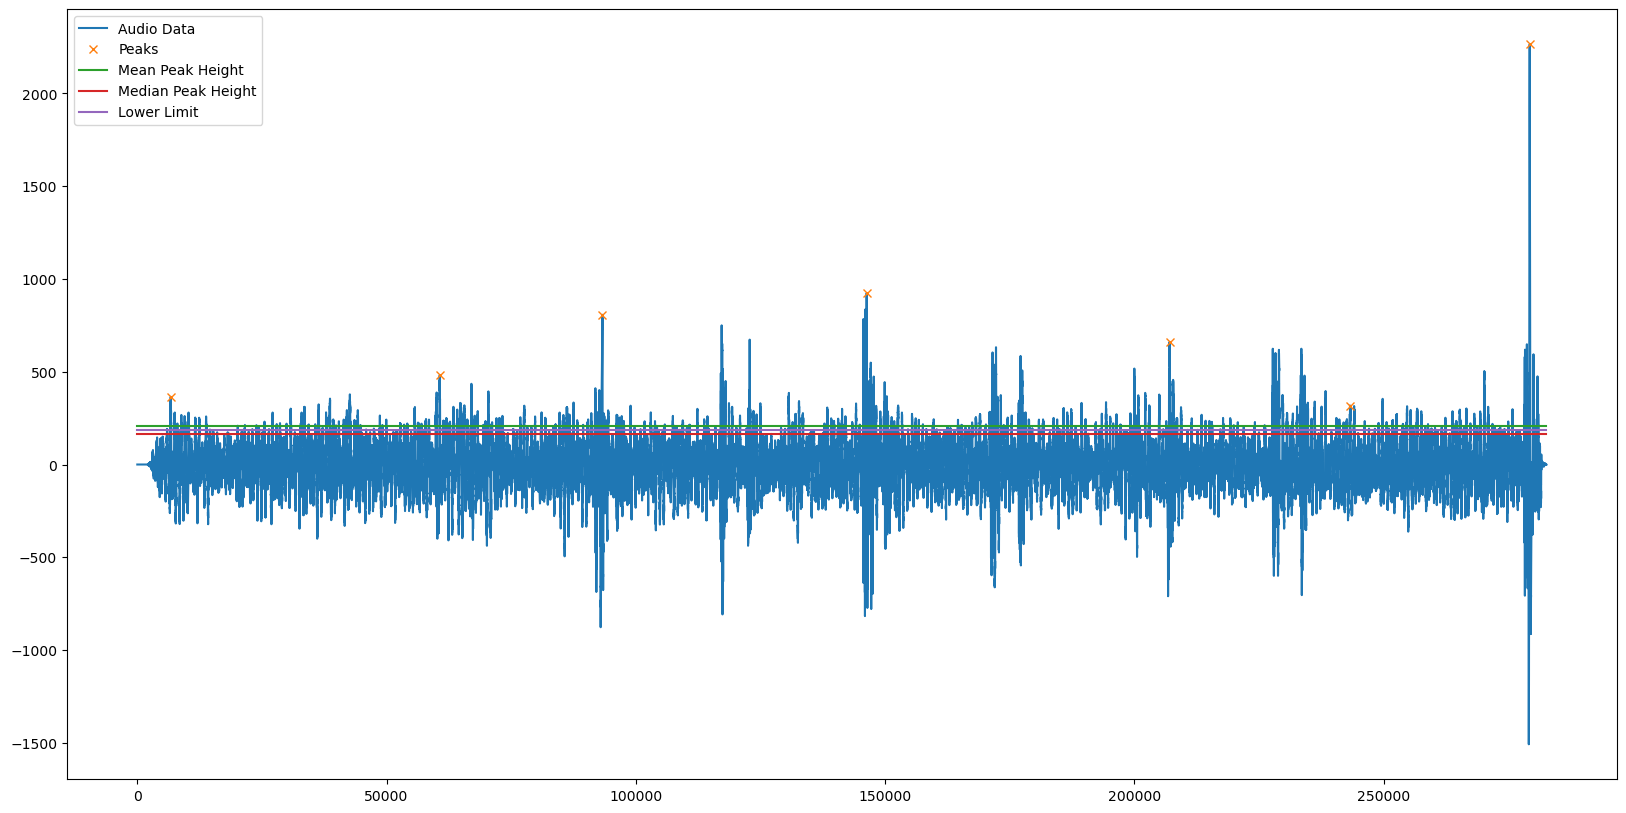

Peak amount: 7
while
silence:1201
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1121
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1051
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:989
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:934
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:885
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:841
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:801
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:764
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:731
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:700
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:672
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:647
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
s

In [20]:
#custom class demonstration
from NoiseFilter import peakIdentification as nf

peakFinderBase=nf(audio_base, audio_for_profile)
base_chunks,base_chunks_n=peakFinderBase.divide_into_chunks()


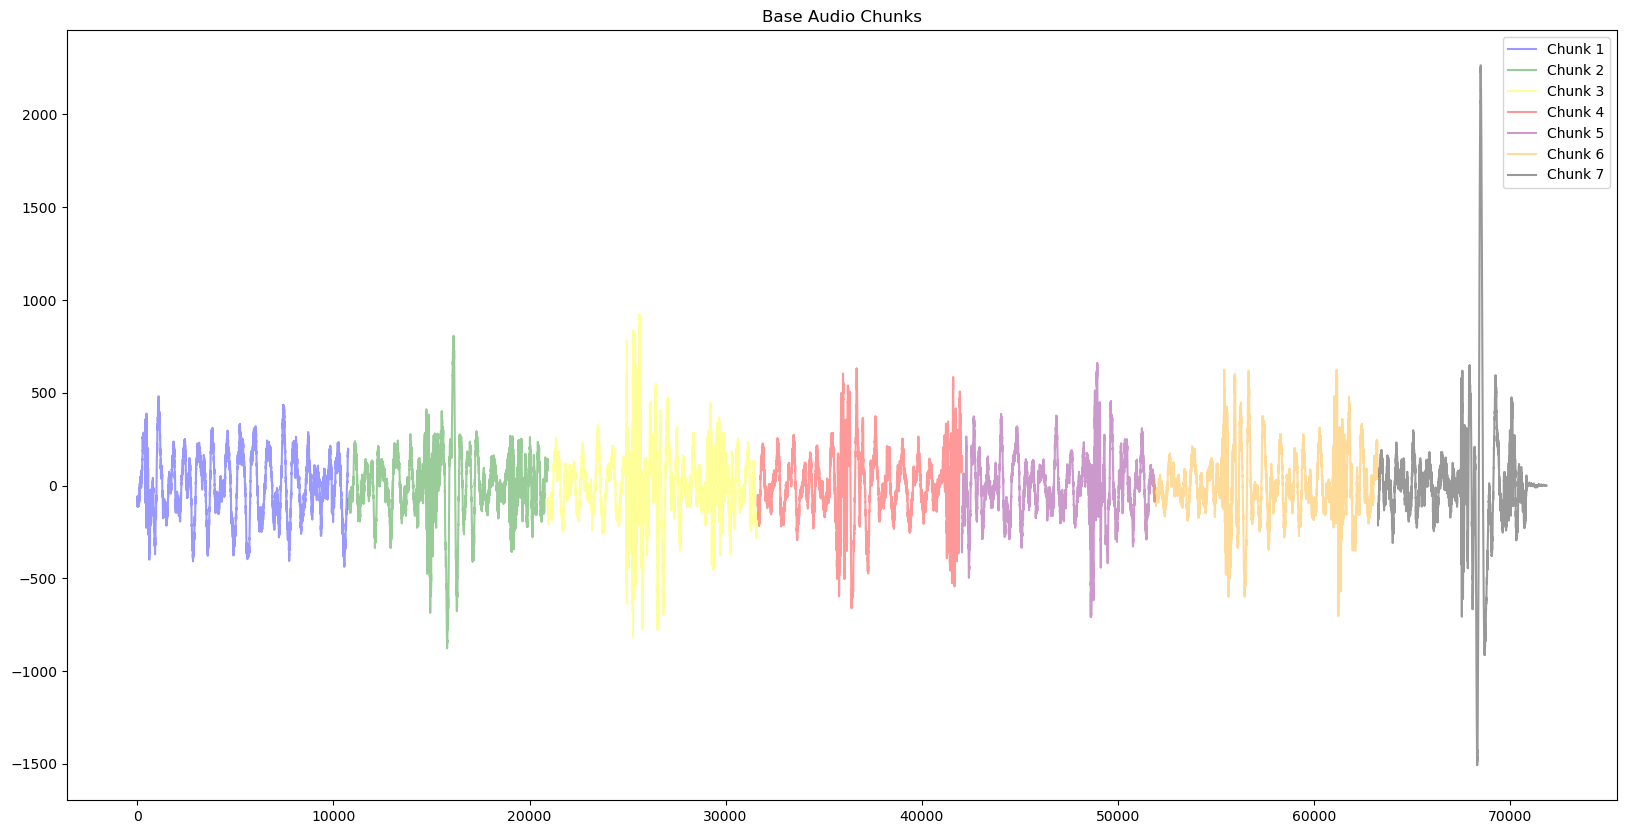

In [55]:
# Calculate the lengths of each chunk
chunk_lengths_base = [len(chunk) for chunk in base_chunks]
x_offset_base = np.cumsum([0]+chunk_lengths_base[:-1])

#graph this
plt.figure(figsize=(20,10))
colors=['blue','green','yellow','red','purple','orange','black','pink','brown','gray', 'lightgrey','lightpink','lightsalmon','lightseagreen','lightskyblue','lightslategray','lightsteelblue','lightyellow','lime','limegreen','linen','magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen','mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','mintcream','mistyrose','moccasin','navajowhite','navy','oldlace','olive','olivedrab','orange','orangered','orchid','palegoldenrod','palegreen','paleturquoise','palevioletred','papayawhip','peachpuff','peru','pink','plum','powderblue','purple','rebeccapurple','rosybrown','royalblue','saddlebrown','salmon','sandybrown','seagreen','tomato','seashell','sienna','silver','skyblue','slateblue','slategray','snow','steelblue','tan','teal','thistle','turquoise','violet','wheat','whitesmoke','yellowgreen']	

for i, (chunk, x_offset_base) in enumerate(zip(base_chunks, x_offset_base)):
    x=np.arange(len(chunk))+x_offset_base
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Base Audio Chunks")
plt.legend()
plt.show()


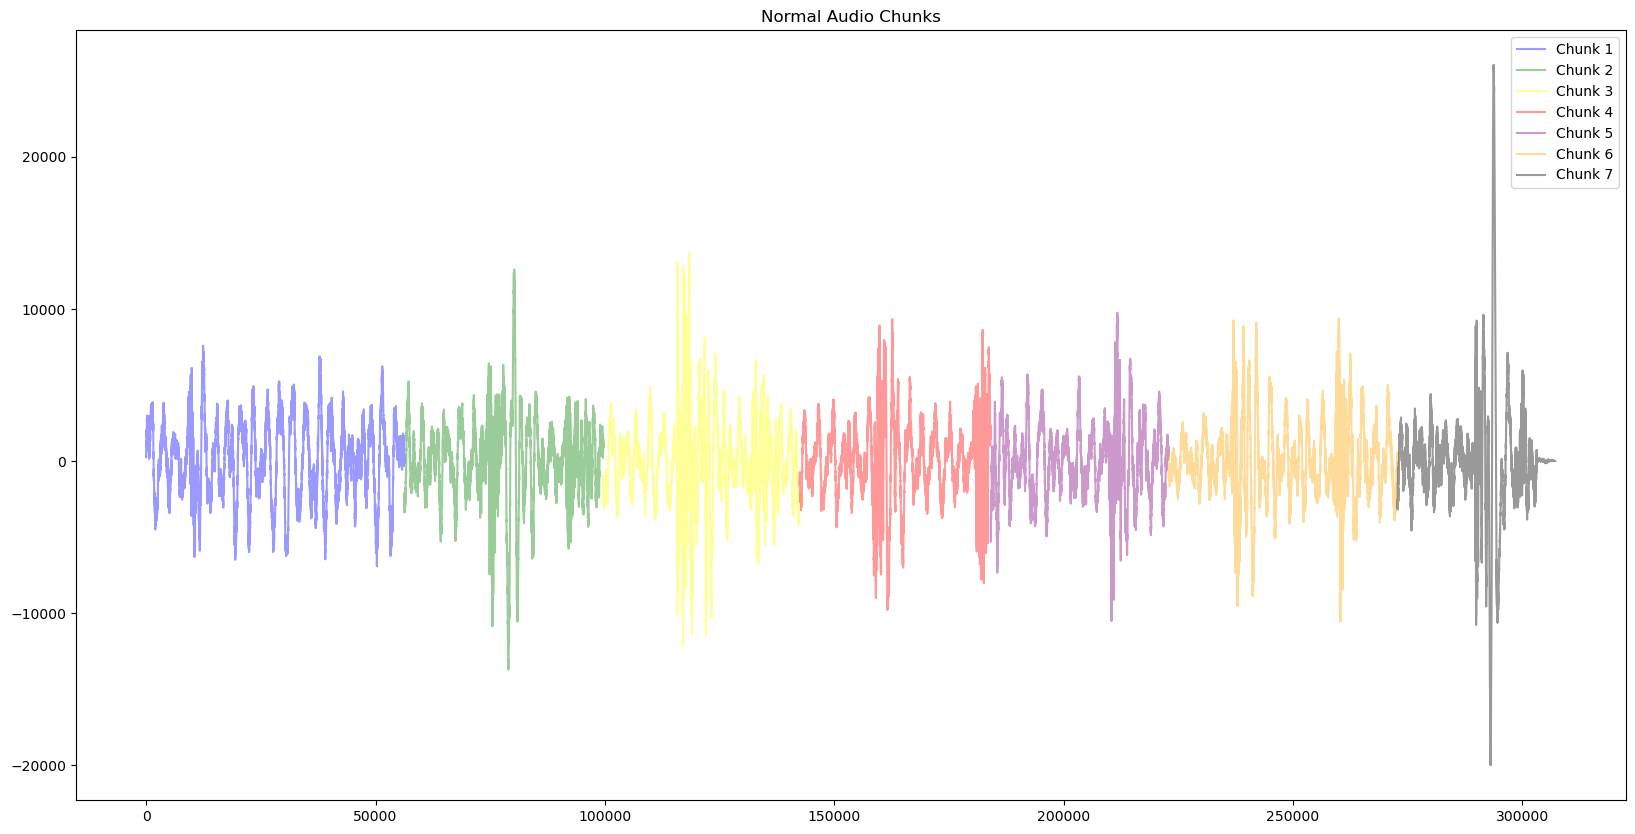

In [56]:
# Calculate the lengths of each chunk
chunk_lengths_normal = [len(chunk) for chunk in normalized_chunks]
x_offset_normal = np.cumsum([0]+chunk_lengths_normal[:-1])

#graph this
plt.figure(figsize=(20,10))

for i, (chunk, x_offset_normal) in enumerate(zip(normalized_chunks, x_offset_normal)):
    x=np.arange(len(chunk))+x_offset_normal
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Normal Audio Chunks")
plt.legend()
plt.show()

## Stationary denoising

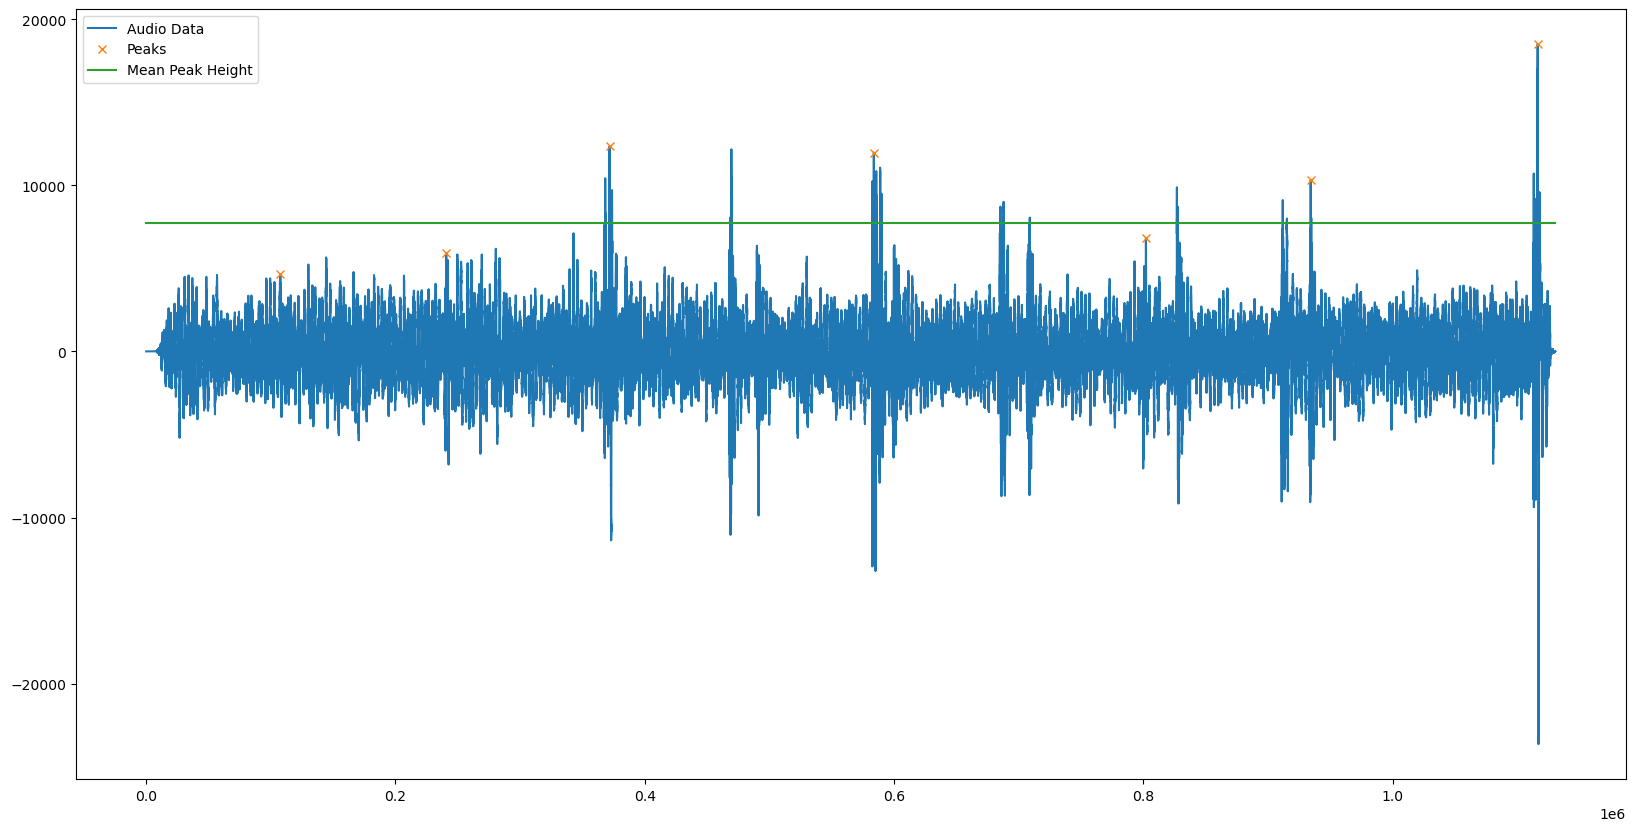

Peak amount: 7
while
silence:1201
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1121
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1051
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:989
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:934
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:885
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:841
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:801
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:764
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:731
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:700
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:672
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:647
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
s

In [57]:
stat_chunks, stat_chunks_n=divide_into_chunks(audio_stat)

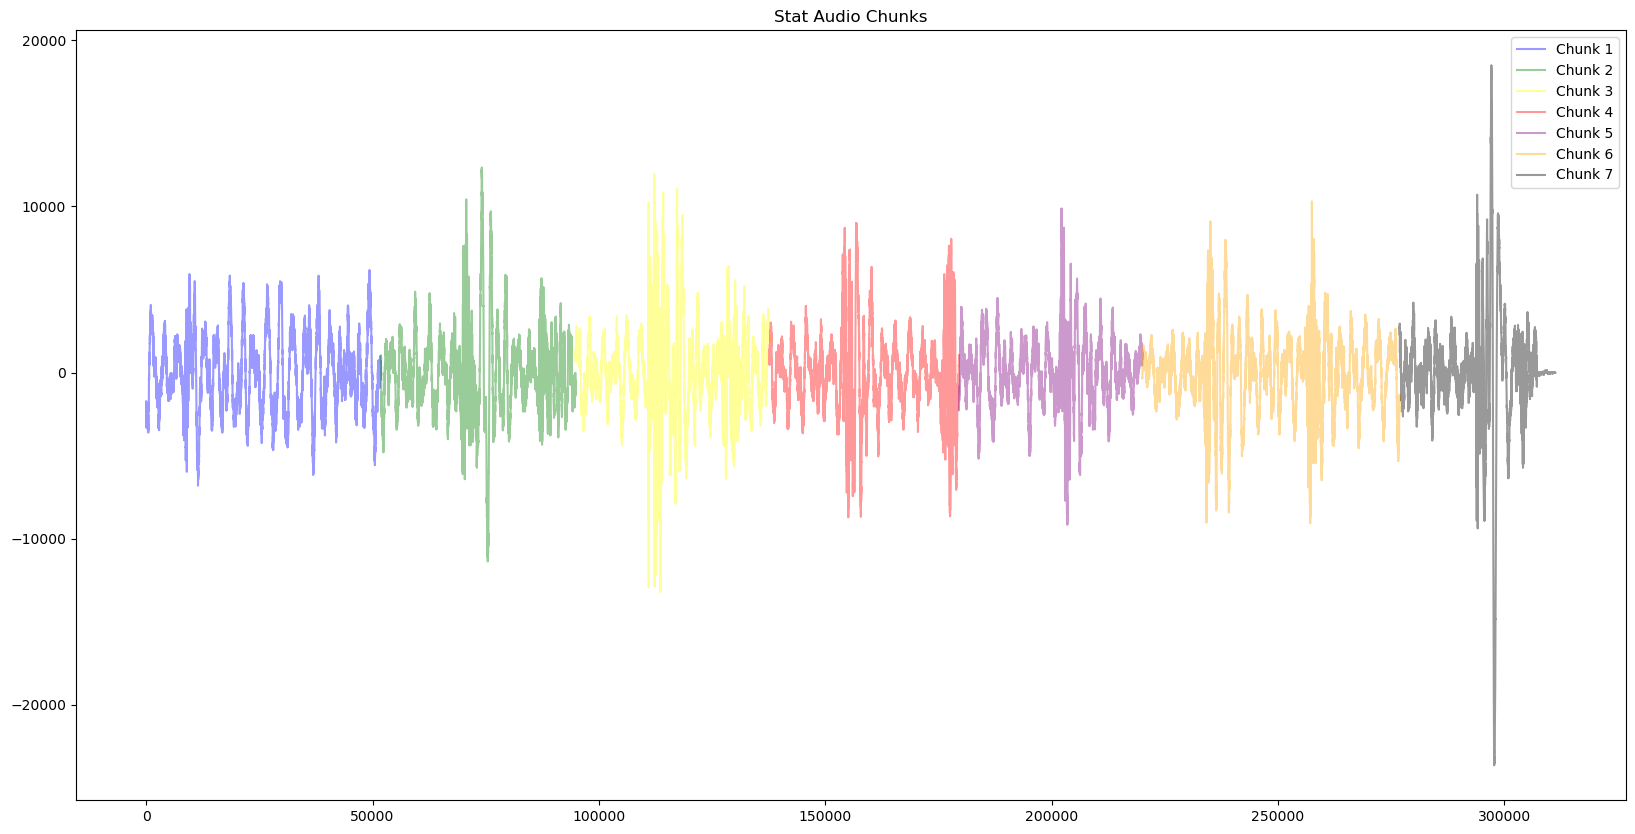

In [58]:
# Calculate the lengths of each chunk
chunk_lengths_stat = [len(chunk) for chunk in stat_chunks]
x_offset_stat = np.cumsum([0]+chunk_lengths_stat[:-1])

#graph this
plt.figure(figsize=(20,10))

for i, (chunk, x_offset_stat) in enumerate(zip(stat_chunks, x_offset_stat)):
    x=np.arange(len(chunk))+x_offset_stat
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Stat Audio Chunks")
plt.legend()
plt.show()

## Non-stationary denoising

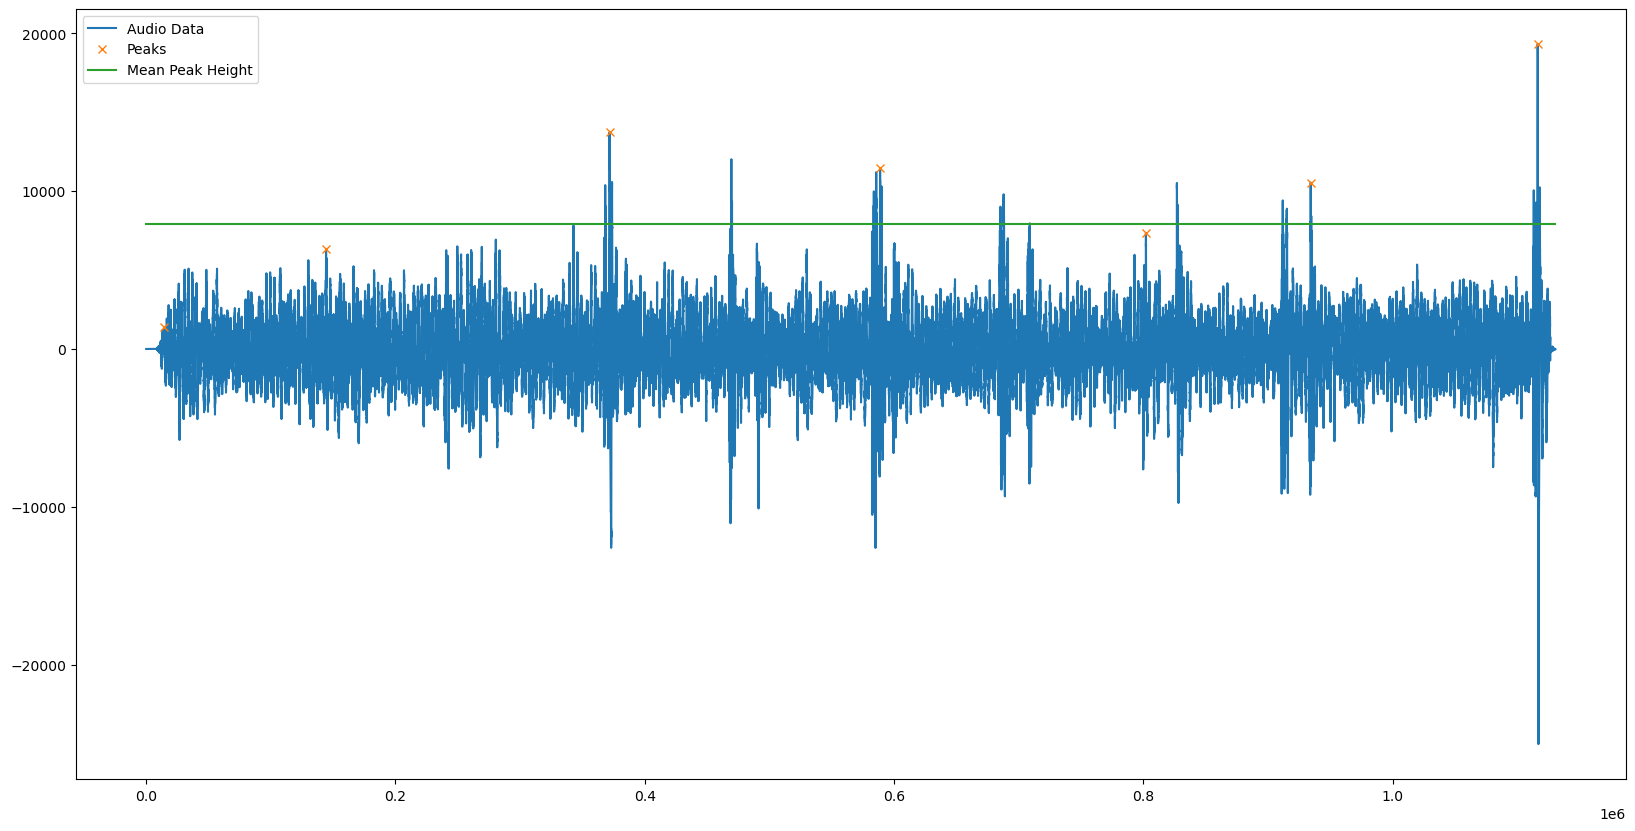

Peak amount: 7
while
silence:1201
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1121
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:1051
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:989
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:934
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:885
Amount of chunks vs expected: 1/7
Augmenting rate.
-----
while
silence:841
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:801
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:764
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:731
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:700
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:672
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
silence:647
Amount of chunks vs expected: 2/7
Augmenting rate.
-----
while
s

In [59]:
nonstat_chunks, nonstat_chunks_n=divide_into_chunks(audio_nonstat)

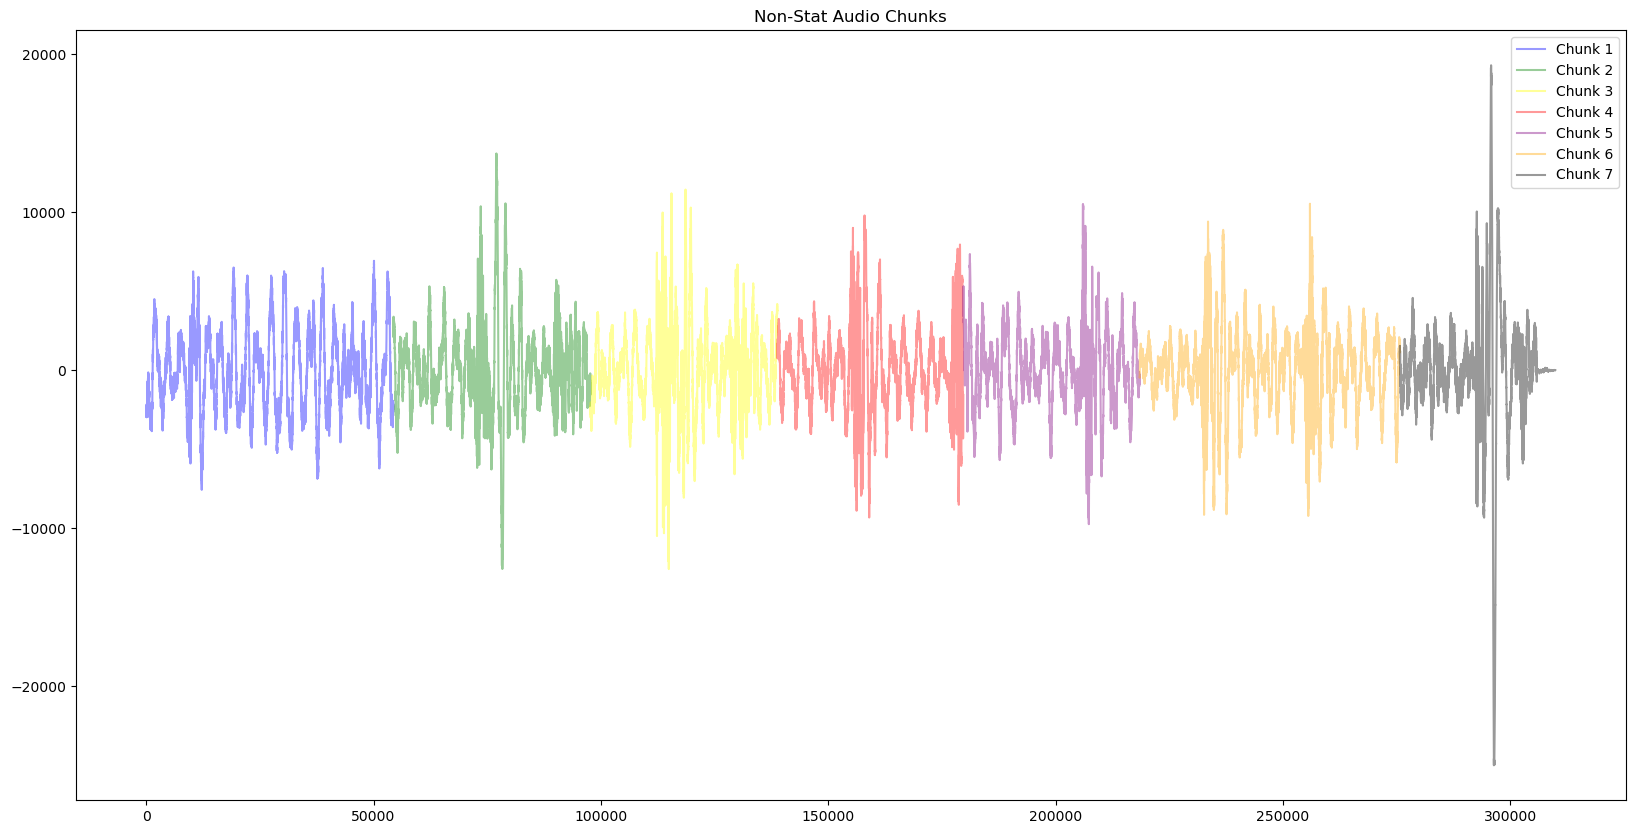

In [60]:
# Calculate the lengths of each chunk
chunk_lengths_nonstat = [len(chunk) for chunk in nonstat_chunks]
x_offset_nonstat = np.cumsum([0]+chunk_lengths_nonstat[:-1])

#graph this
plt.figure(figsize=(20,10))

for i, (chunk, x_offset_nonstat) in enumerate(zip(nonstat_chunks, x_offset_nonstat)):
    x=np.arange(len(chunk))+x_offset_nonstat
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Non-Stat Audio Chunks")
plt.legend()
plt.show()

## Splitting audio by average chunk calculation

This one is a bad idea and we shouldn't do it!

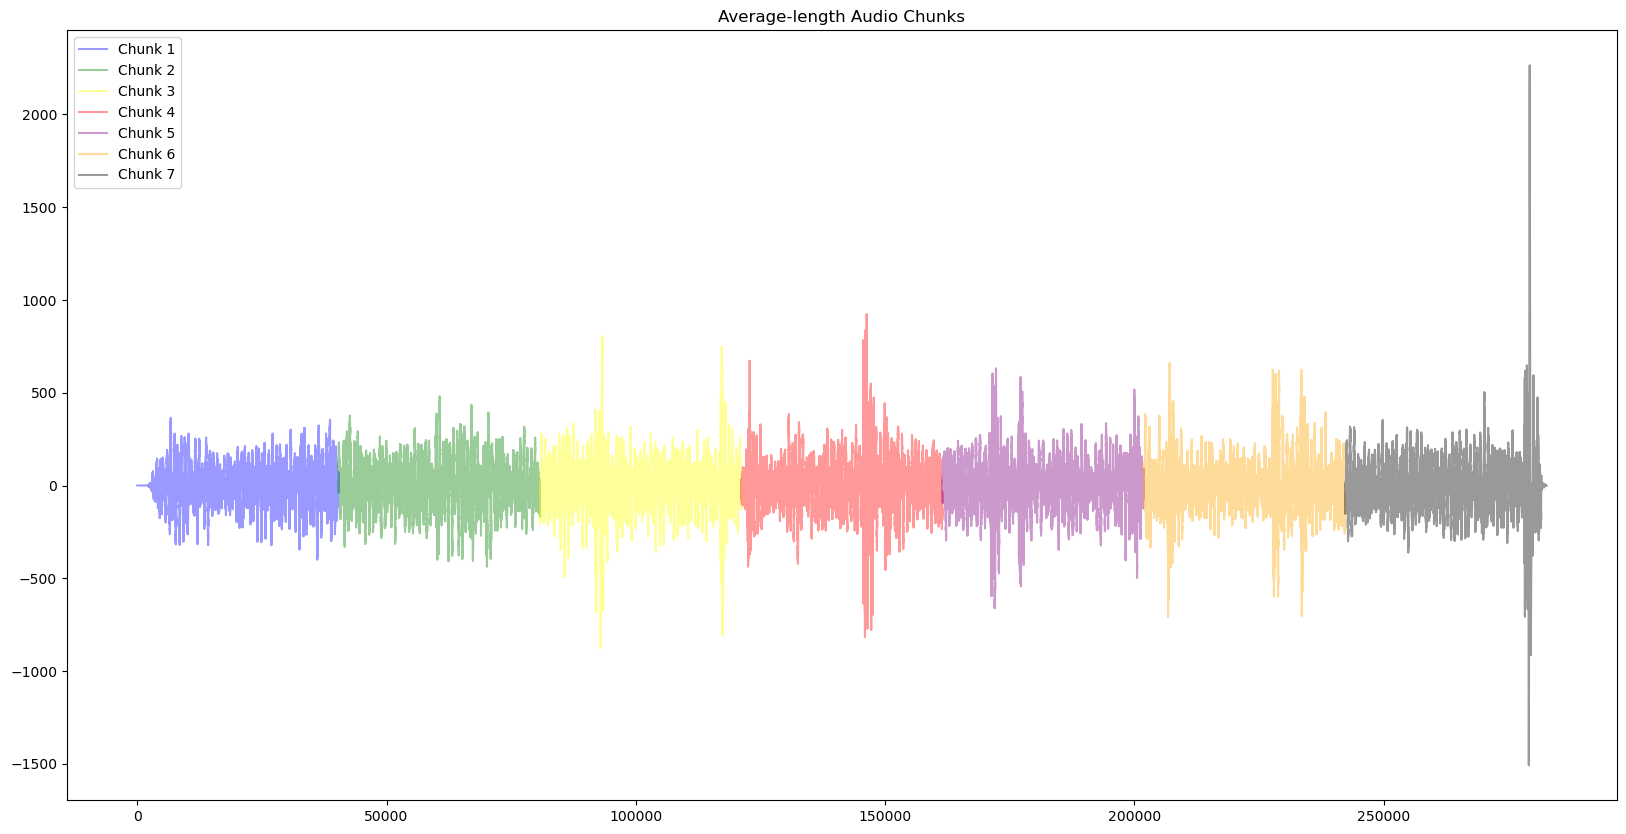

In [61]:
# average chunk count
average_chunk_count = (base_chunks_n+normalized_chunks_n+stat_chunks_n+nonstat_chunks_n)/4

#split audio by average chunk count
def split_audio_count(audio, n_chunks):
    #calculate chunk length
    length=len(audio)/n_chunks

    #split audio
    chunks=[audio[i*length:(i+1)*length] for i in range(int(n_chunks))]
    
    # Convert chunks to numpy arrays
    chunk_arrays = [np.array(chunk.get_array_of_samples()) for chunk in chunks]
    
    #return amount of chunks
    return len(chunks), chunk_arrays

#splitting
average_chunk_n, average_chunks = split_audio_count(audio_base, average_chunk_count)

#graph that shit
# Calculate the lengths of each chunk
chunk_lengths_avg = [len(chunk) for chunk in average_chunks]
x_offset_avg = np.cumsum([0]+chunk_lengths_avg[:-1])

#graph this
plt.figure(figsize=(20,10))

for i, (chunk, x_offset_avg) in enumerate(zip(average_chunks, x_offset_avg)):
    x=np.arange(len(chunk))+x_offset_avg
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Average-length Audio Chunks")
plt.legend()
plt.show()

# Tests using peak identification to split audio

In [35]:
audio_key_0_normal = pydub.AudioSegment.from_file("../Dataset-custom-audio/base-audio-normalized-only/N.wav")
audio_key_0_denoised = pydub.AudioSegment.from_file("../Dataset-custom-audio/base-audio-denoised-normalized/N.wav")

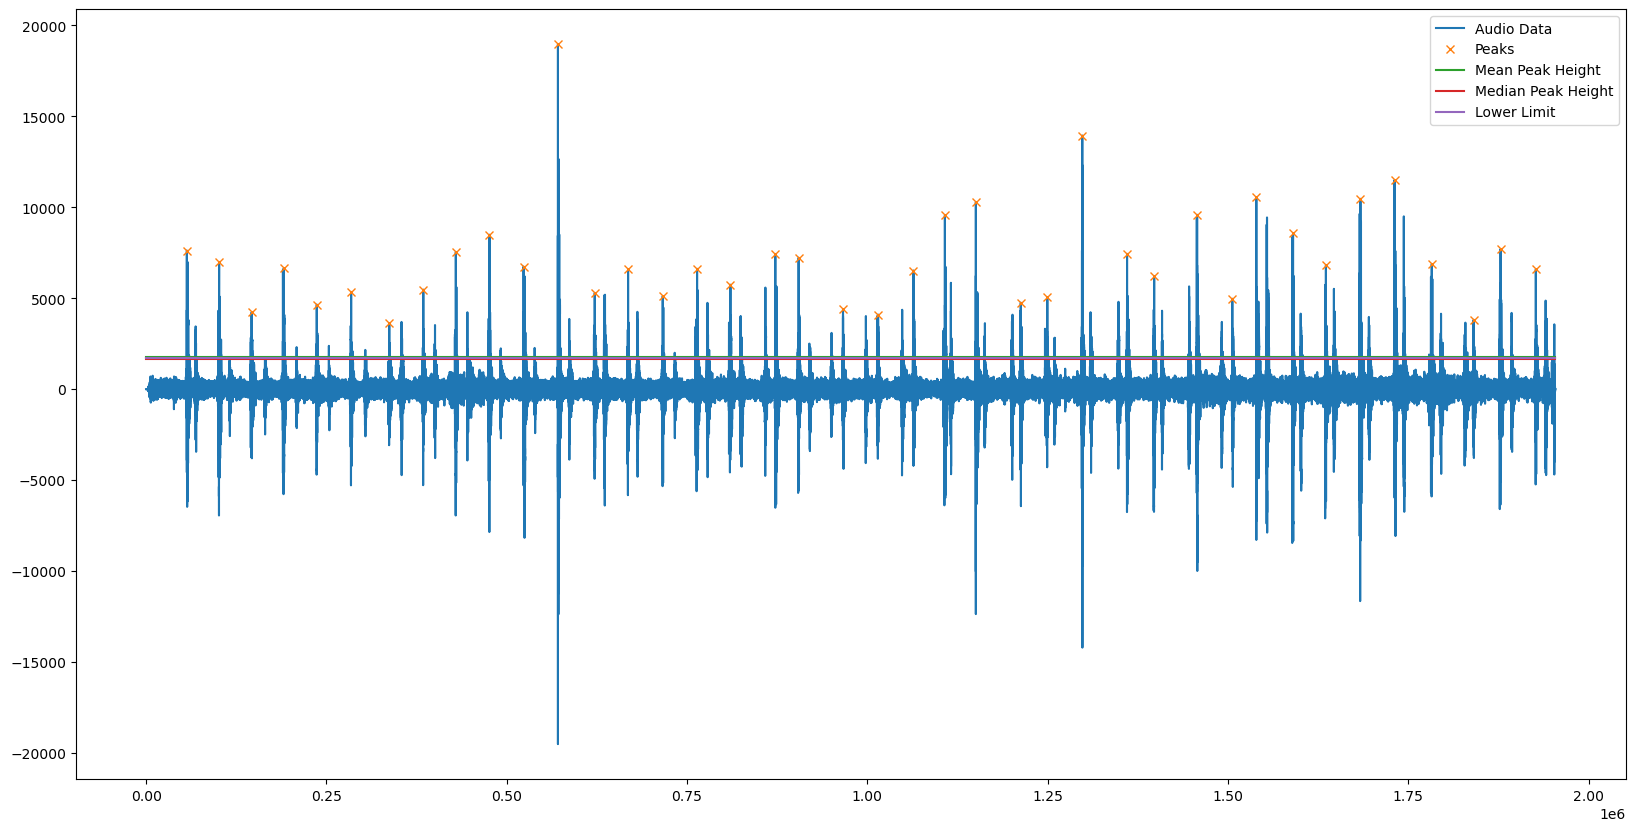

Peak amount: 40
while
silence:254
Amount of chunks vs expected: 29/40
Augmenting rate.
-----
while
silence:251
Amount of chunks vs expected: 29/40
Augmenting rate.
-----
while
silence:248
Amount of chunks vs expected: 29/40
Augmenting rate.
-----
while
silence:245
Amount of chunks vs expected: 31/40
Augmenting rate.
-----
while
silence:242
Amount of chunks vs expected: 32/40
Augmenting rate.
-----
while
silence:239
Amount of chunks vs expected: 32/40
Augmenting rate.
-----
while
silence:236
Amount of chunks vs expected: 31/40
Augmenting rate.
-----
while
silence:233
Amount of chunks vs expected: 34/40
Augmenting rate.
-----
while
silence:231
Amount of chunks vs expected: 34/40
Augmenting rate.
-----
while
silence:228
Amount of chunks vs expected: 35/40
Augmenting rate.
-----
while
silence:226
Amount of chunks vs expected: 37/40
Augmenting rate.
-----
while
silence:223
Amount of chunks vs expected: 36/40
Augmenting rate.
-----
while
silence:221
Amount of chunks vs expected: 37/40
Augmen

In [36]:
denoised_chunks_0,denoised_chunks_n_0=divide_into_chunks(audio_key_0_denoised)

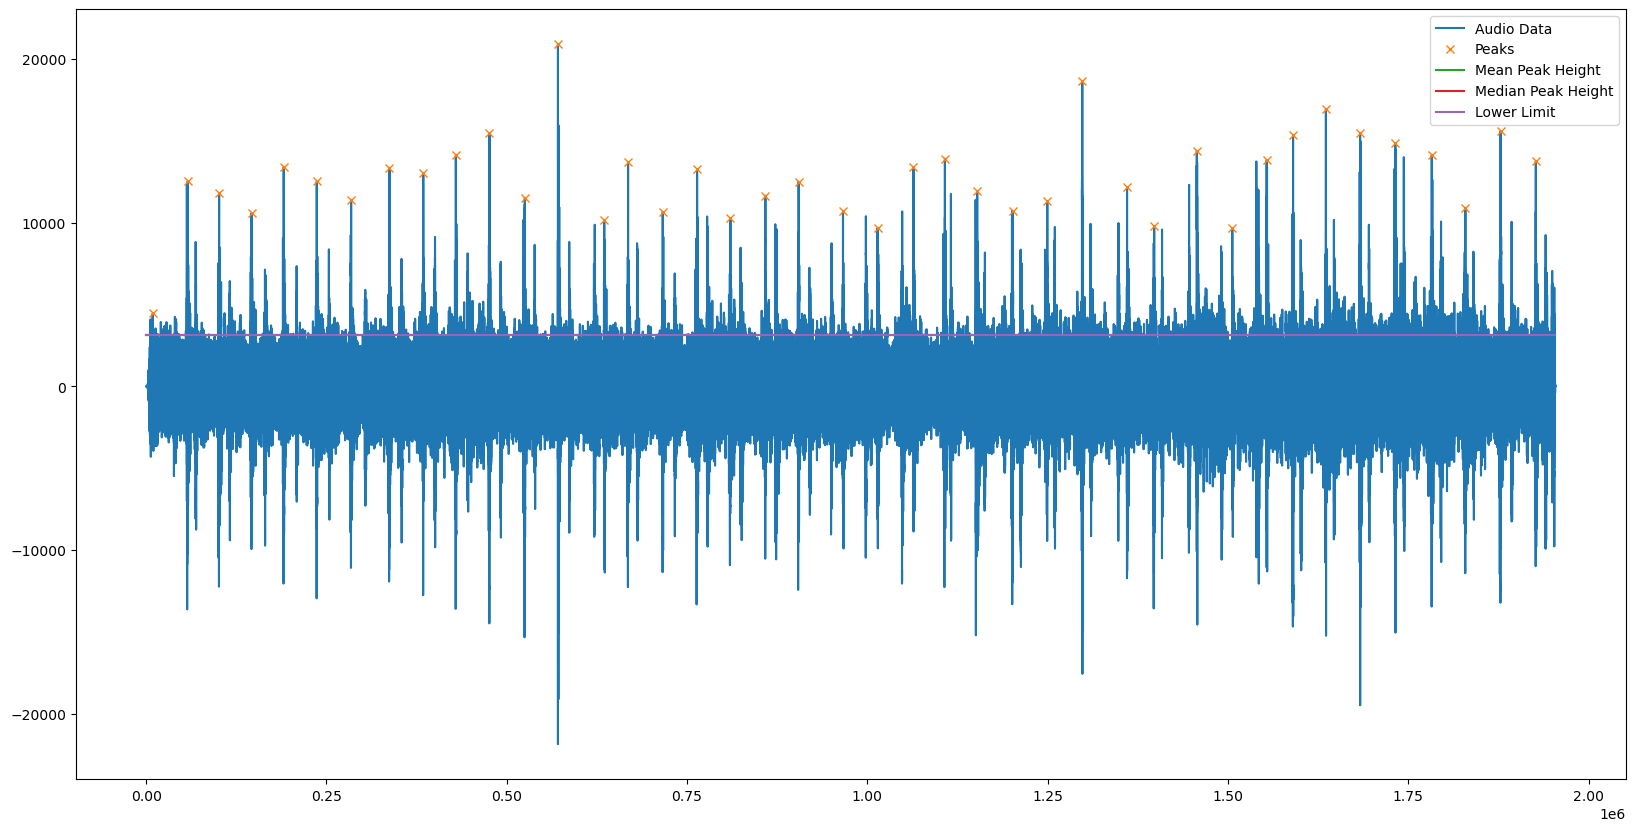

Peak amount: 41
while
silence:242
Amount of chunks vs expected: 39/41
Augmenting rate.
-----
while
silence:239
Amount of chunks vs expected: 39/41
Augmenting rate.
-----
while
silence:236
Amount of chunks vs expected: 40/41
Augmenting rate.
-----
while
silence:233
Amount of chunks vs expected: 40/41
Augmenting rate.
-----
while
silence:230
Amount of chunks vs expected: 42/41
Diminishing rate.
-----
while
silence:233
Amount of chunks vs expected: 40/41
Augmenting rate.
-----
while
silence:230
Amount of chunks vs expected: 42/41
Diminishing rate.
-----
while
silence:233
Amount of chunks vs expected: 40/41
Rate is stuck; selecting closest accurate.


In [37]:
normal_chunks_0,normal_chunks_n_0=divide_into_chunks(audio_key_0_normal)


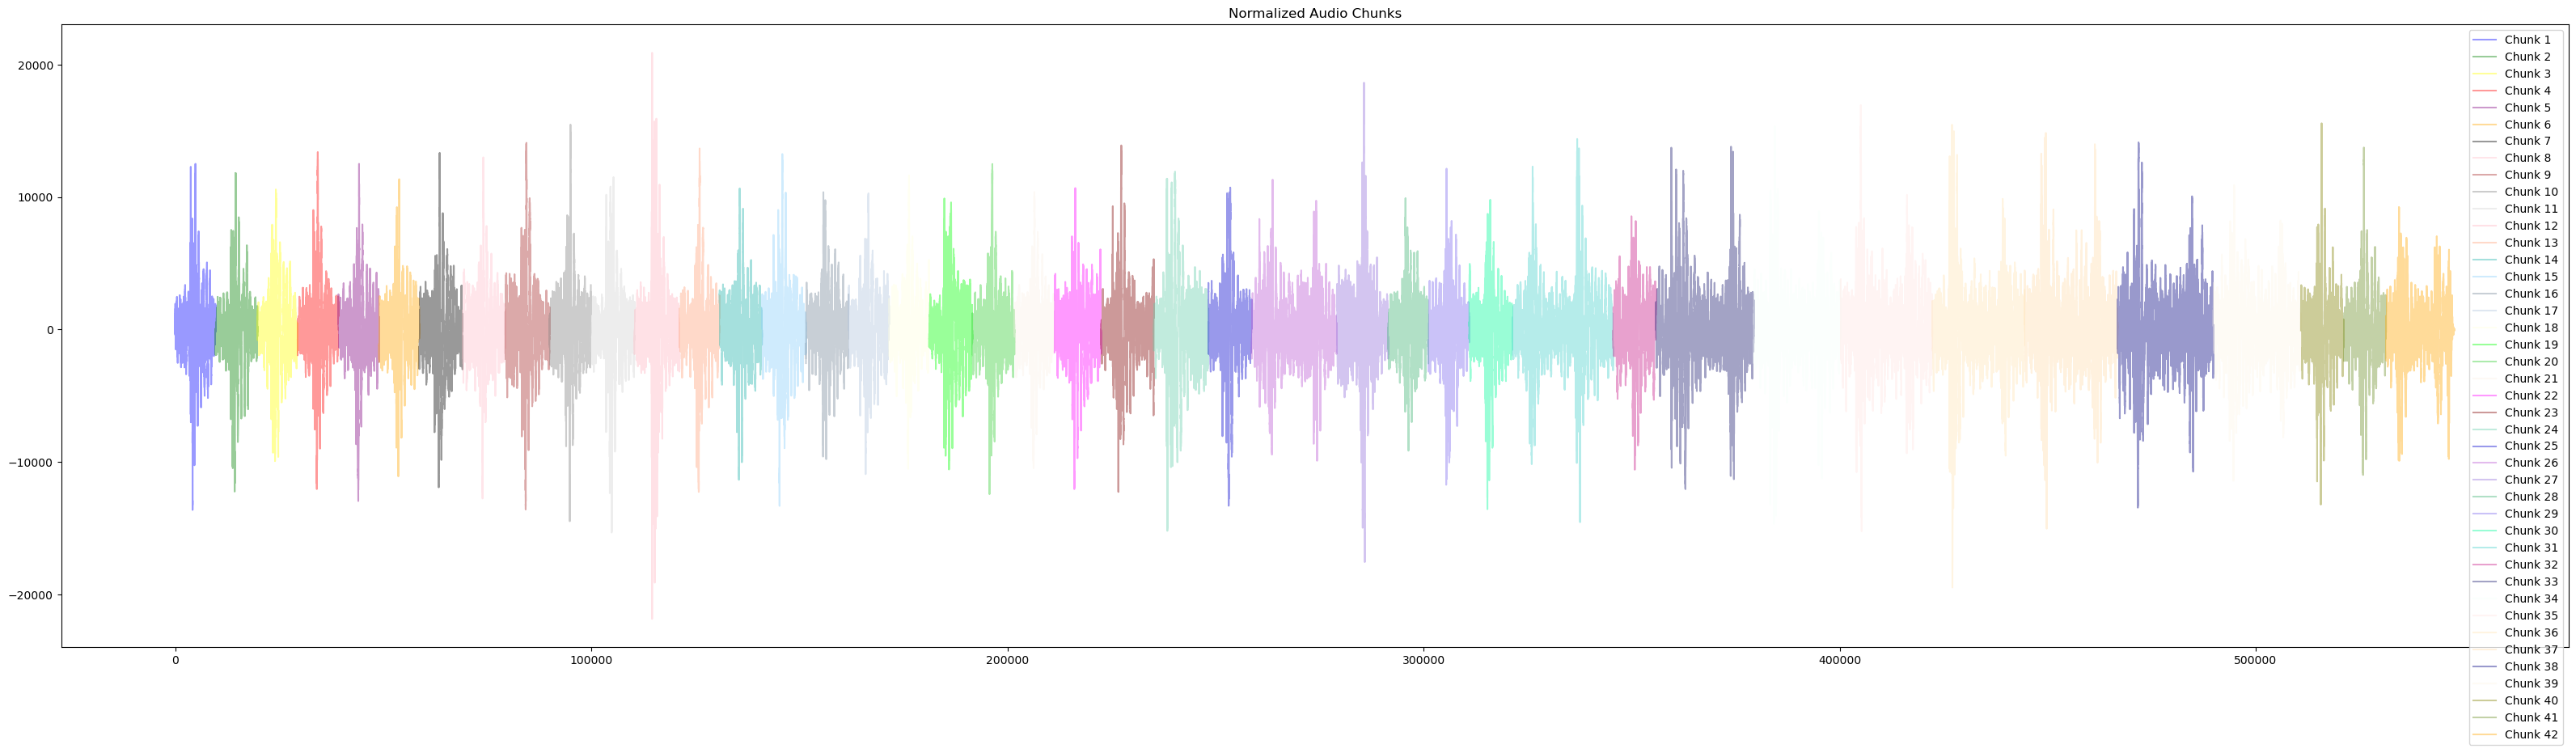

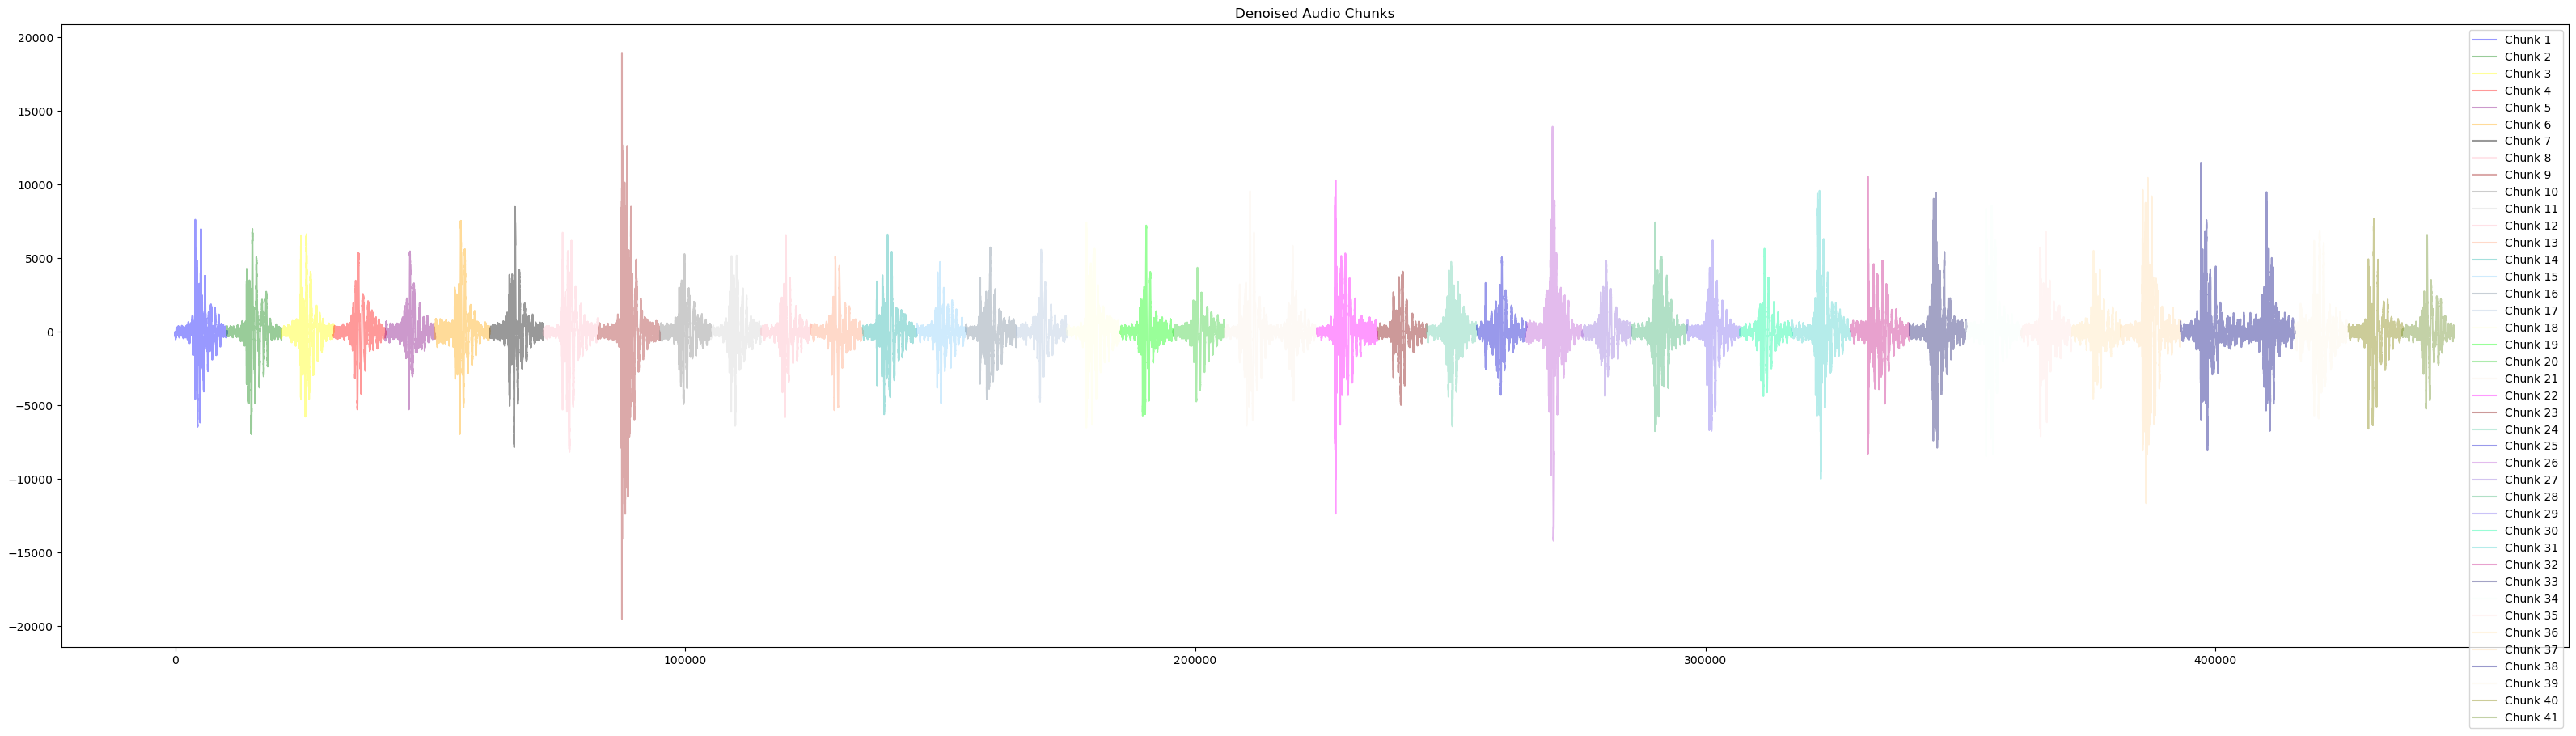

In [65]:
# Calculate the lengths of each chunk - normalized
chunk_lengths_n0 = [len(chunk) for chunk in normal_chunks_0]
x_offset_normal_0 = np.cumsum([0]+chunk_lengths_n0[:-1])

#graph this
plt.figure(figsize=(40,10))

for i, (chunk, x_offset_normal_0) in enumerate(zip(normal_chunks_0, x_offset_normal_0)):
    x=np.arange(len(chunk))+x_offset_normal_0
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Normalized Audio Chunks")
plt.legend()
plt.show()

# Calculate the lengths of each chunk - denoised
chunk_lengths_d0 = [len(chunk) for chunk in denoised_chunks_0]
x_offset_denoised_0 = np.cumsum([0]+chunk_lengths_d0[:-1])

#graph this
plt.figure(figsize=(40,10))

for i, (chunk, x_offset_denoised_0) in enumerate(zip(denoised_chunks_0, x_offset_denoised_0)):
    x=np.arange(len(chunk))+x_offset_denoised_0
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Denoised Audio Chunks")
plt.legend()
plt.show()

## Third test

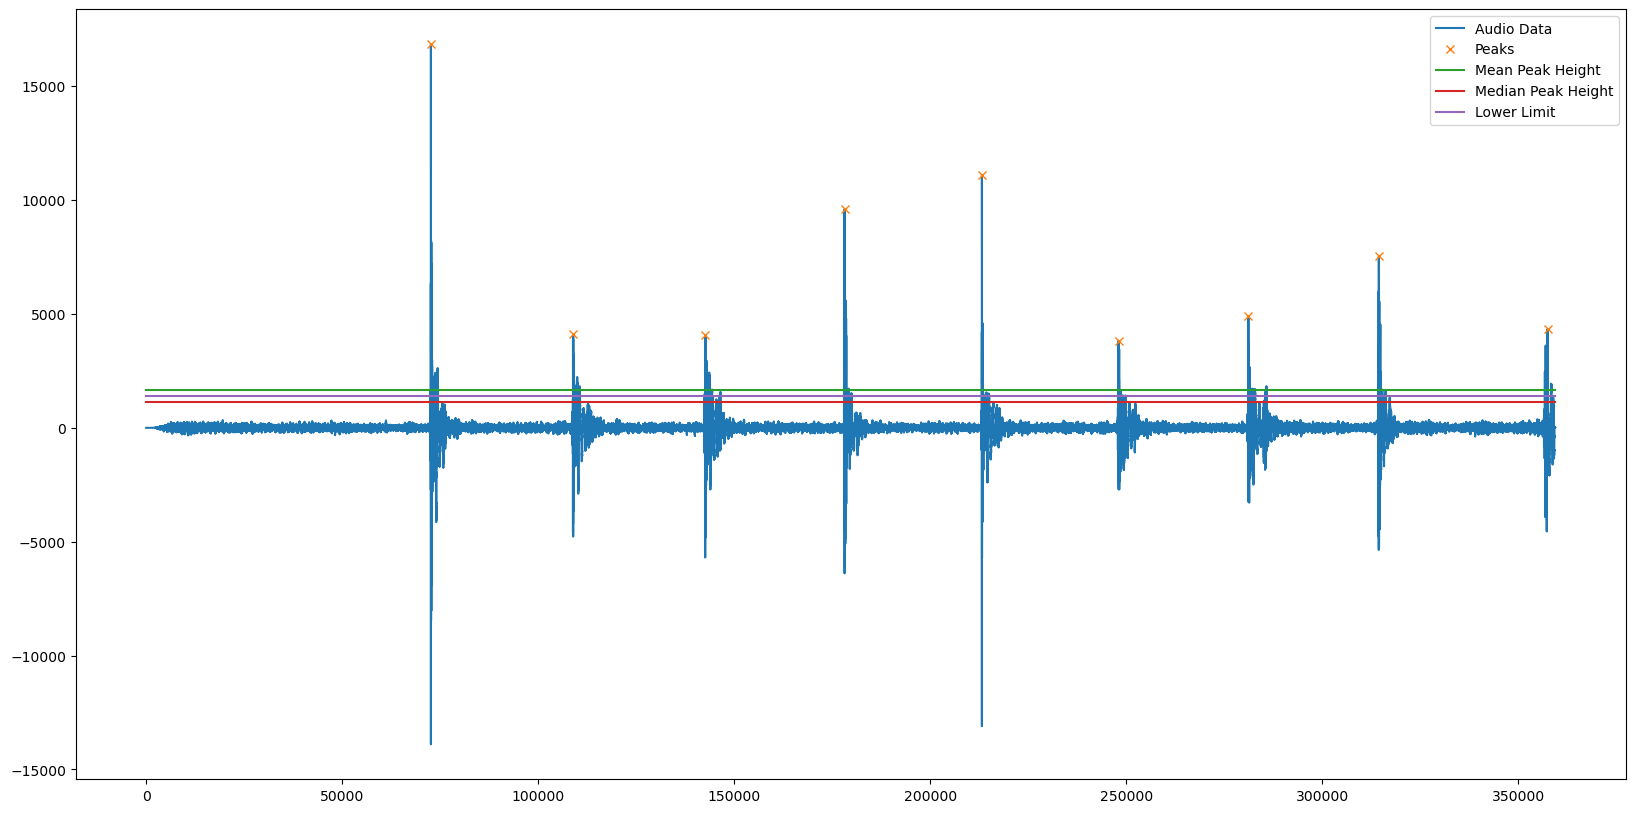

Peak amount: 9
while
silence:924
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:875
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:832
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:792
Amount of chunks vs expected: 3/9
Augmenting rate.
-----
while
silence:756
Amount of chunks vs expected: 3/9
Augmenting rate.
-----
while
silence:723
Amount of chunks vs expected: 3/9
Augmenting rate.
-----
while
silence:693
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:665
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:639
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:616
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:594
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:573
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
silence:554
Amount of chunks vs expected: 2/9
Augmenting rate.
-----
while
sile

NameError: name 'colors' is not defined

<Figure size 4000x1000 with 0 Axes>

In [38]:
# Load audio file
audio_holahola = pydub.AudioSegment.from_file("../Dataset-custom-audio/audio-standby-files/audio-hola/audio_hola.wav")

# Split audio into chunks
chunks_hola,_=divide_into_chunks(audio_holahola)

# Plotting the chunks
# Calculate the lengths of each chunk - normalized
chunk_lengths_hola = [len(chunk) for chunk in chunks_hola]
x_offset_hola = np.cumsum([0]+chunk_lengths_hola[:-1])

#graph this
plt.figure(figsize=(40,10))

for i, (chunk, x_offset_hola) in enumerate(zip(chunks_hola, x_offset_hola)):
    x=np.arange(len(chunk))+x_offset_hola
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("'HolaHola' Audio Chunks")
plt.legend()
plt.show()

## Fourth test

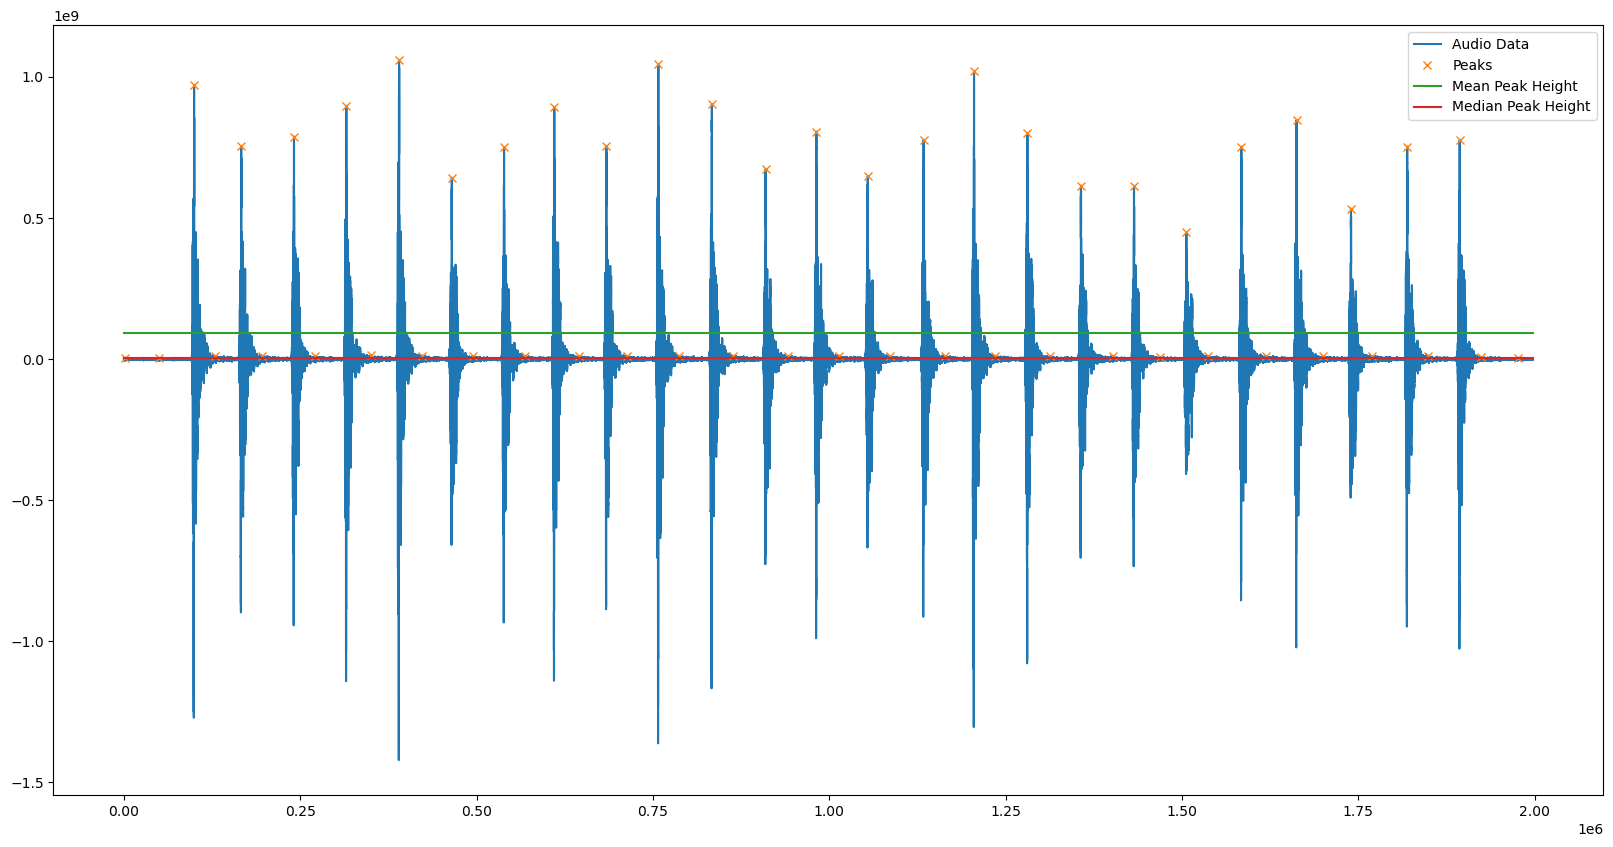

53

In [22]:
# Load audio file
audio_holahola = pydub.AudioSegment.from_file("../Dataset-for-Binary/base-audio/audio_W.wav")

find_n_peaks(audio_holahola)

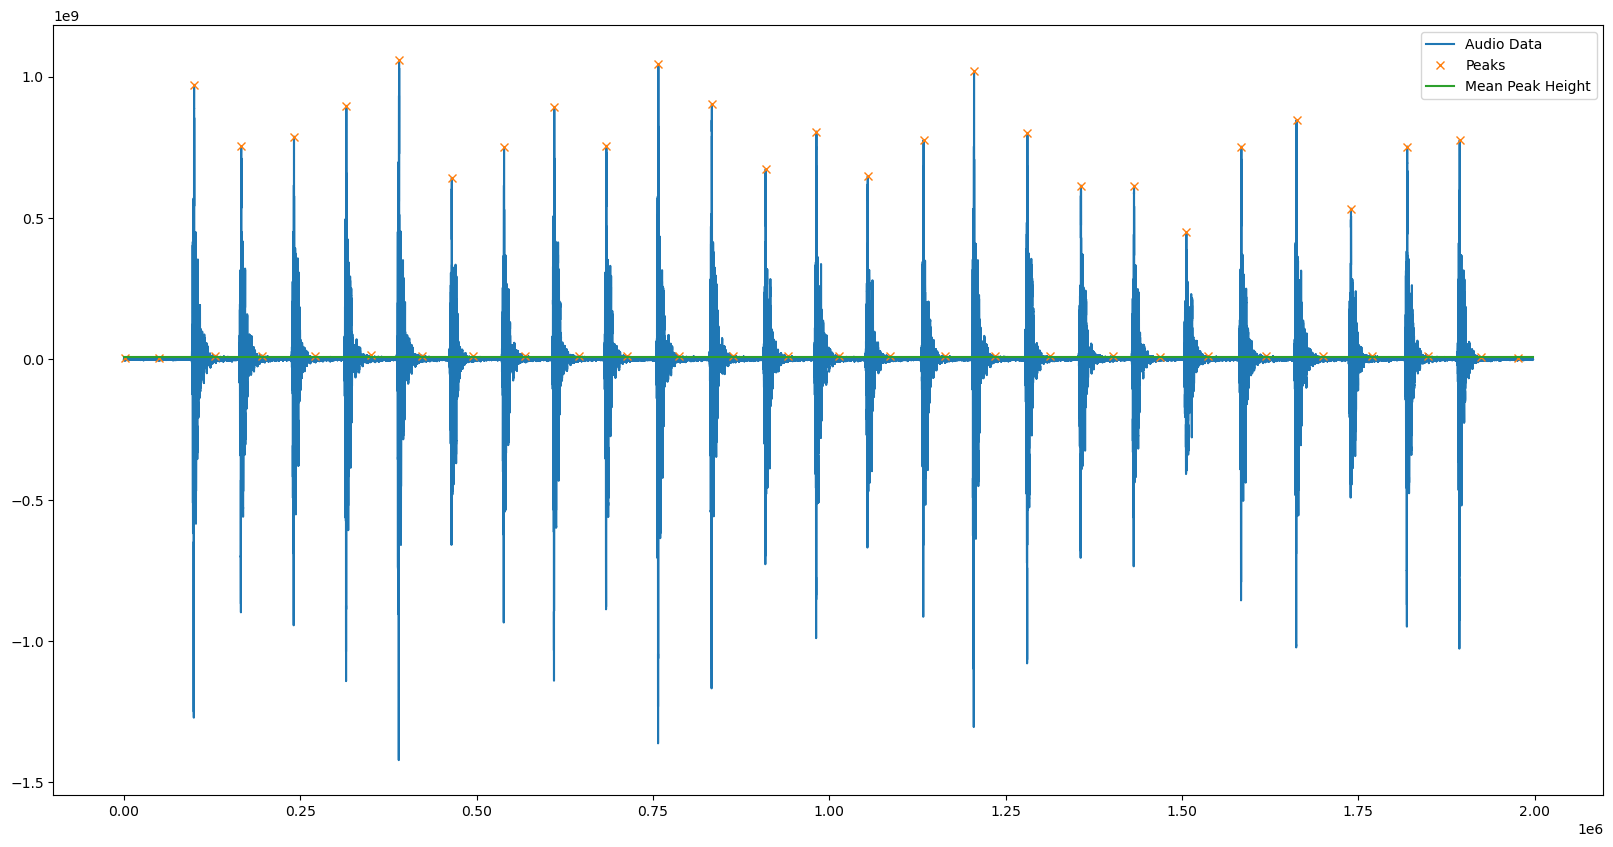

Peak amount: 53
while
silence:80
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:79
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:79
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:78
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:77
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:76
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:76
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:75
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:74
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:74
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:73
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:73
Amount of chunks vs expected: 25/53
Augmenting rate.
-----
while
silence:72
Amount of chunks vs expected: 25/53
Augmenting rate.
--

: 

In [69]:
# Load audio file
audio_holahola = pydub.AudioSegment.from_file("../Dataset-for-Binary/base-audio/audio_W.wav")

# Split audio into chunks
chunks_hola,_=divide_into_chunks(audio_holahola)

# Plotting the chunks
# Calculate the lengths of each chunk - normalized
chunk_lengths_hola = [len(chunk) for chunk in chunks_hola]
x_offset_hola = np.cumsum([0]+chunk_lengths_hola[:-1])

#graph this
plt.figure(figsize=(40,10))

for i, (chunk, x_offset_hola) in enumerate(zip(chunks_hola, x_offset_hola)):
    x=np.arange(len(chunk))+x_offset_hola
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("'HolaHola' Audio Chunks")
plt.legend()
plt.show()

audio_array: [ 1  0 -2 ... 11  6 10]
distance: 29390.14682492285
audio mean: -31.185630089687088


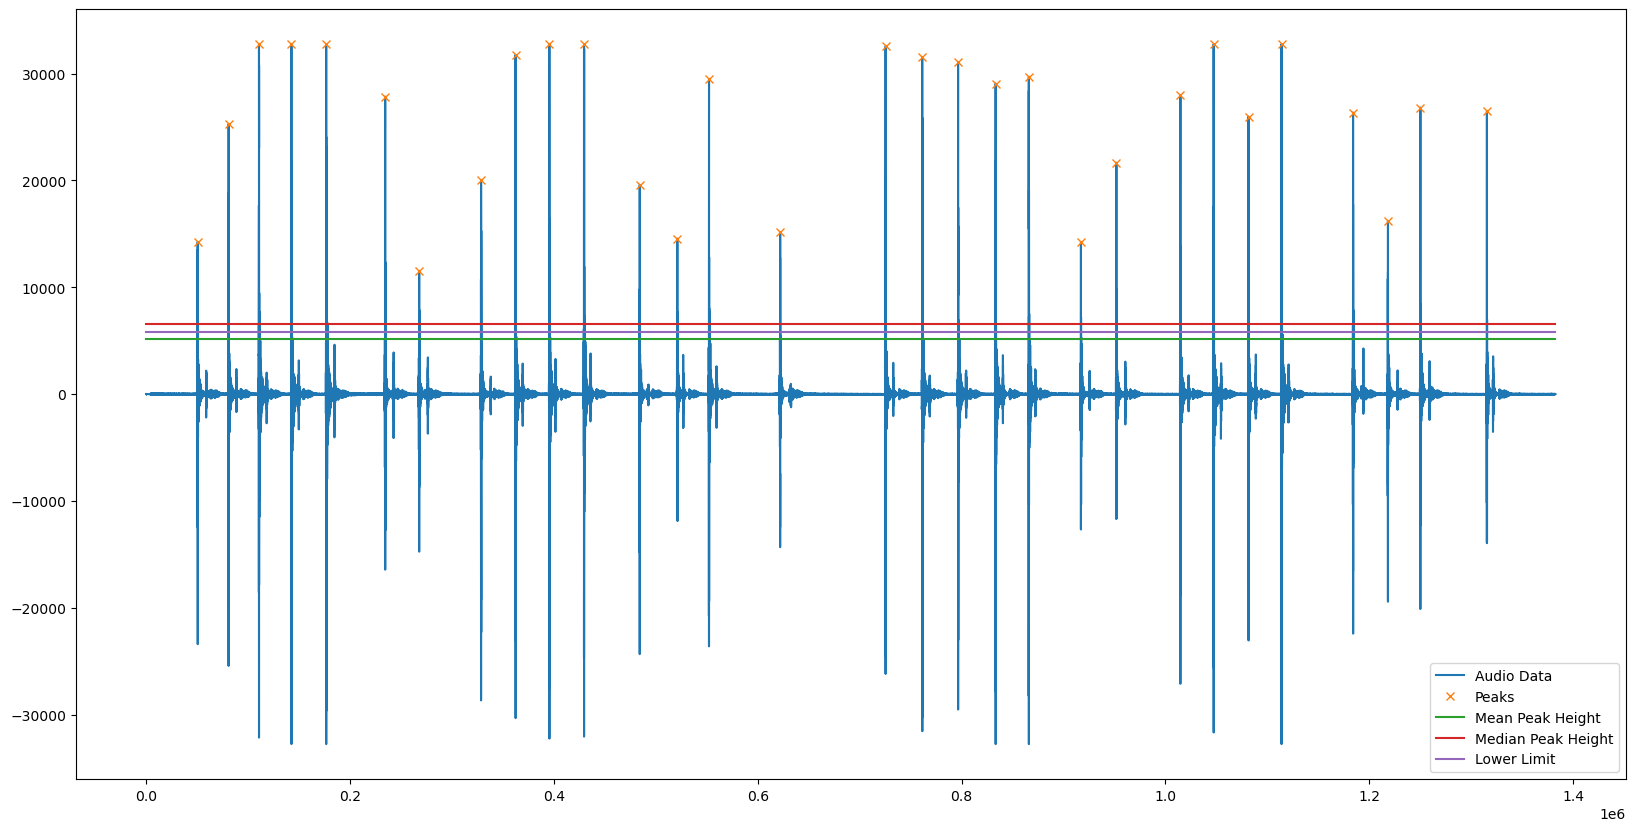

Peak amount: 30
while
silence:174
Amount of chunks vs expected: 21/30
Augmenting rate.
-----
while
silence:171
Amount of chunks vs expected: 21/30
Augmenting rate.
-----
while
silence:168
Amount of chunks vs expected: 22/30
Augmenting rate.
-----
while
silence:165
Amount of chunks vs expected: 22/30
Augmenting rate.
-----
while
silence:163
Amount of chunks vs expected: 22/30
Augmenting rate.
-----
while
silence:160


KeyboardInterrupt: 

In [7]:
location="../MKA-dataset/"
suffix="mac.wav"
keyset='-+1234567890abcdefghijklmnopqrstuvwxyz'
chunks_amount=[]

for key in keyset:

    #assign audio dir
    location_audio=location+key+suffix

    # Load audio file
    audio_key = pydub.AudioSegment.from_file(location_audio)

    # Split audio into chunks
    _,chunk_amount=divide_into_chunks(audio_key)

    # add to chunk list

    chunks_amount.append(chunk_amount)

# calculate average
chunk_avg=np.average(chunks_amount)
print(f'average amount of chunks: {chunk_avg}')

